In [ ]:




#   in number 1 part a it asks us to make the graphs for n=2 at the bottom is the difference
#    between the exact values and the estimated values
#
#




In [2]:
#%%
"""         Chem 210A/B --  C.W. McCurdy -- January 2021
   
 Read a file with potential curve values and find bound states 
              for particle with specified mass

 Finite Element Method - Discrete Variable Representation (FEM-DVR) 
 for 1D Schroedinger equation using Gauss-Lobatto quadrature in each finite element
 Uses class DVRHelper() to construct FEM-DVR points, weights and Kinetic Energy

 Shows how to 
   (1) Read in and interpolate a potential function known at discrete points
       using cubic spline interpretation
   (2) Use DVRHelper class to build FEM-DVR grid
   (3) Use DVRHelper class to build Hamiltonian in DVR basis
   (4) Find eigenvalues and eigenvectors of Hamiltonian
   (5) Plot eigenfunctions of the Hamiltonian

 Example: Harmonic Oscillator with potential specified at 25 points in x
          on the interval -5 bohr to + 5 bohr.   Solved using a mass of an 
          H atom using a DVR on -2 to 2 bohr.

 Student Exercise: 
          H2 vibrational states using CI singles and doubles potential curve
          from Psi4 provided at 500 input points.
          This potential yields a n = 0 -> 1 excitation energy 
          within a few wavenumbers of the value using the NIST values for
          constants of diatomic molecules for H2 in the formula
           E_n = (n+1/2)we - (n+1/2)^2 wexe, which is 4158 cm^-1

"""
#%%
# preliminaries to invoke SciPy linear algebra functions 
from scipy import linalg as LA
# and NumPy which is used to define pi, sqrt, array, .transpose etc. as np
import numpy as np
from scipy.interpolate import CubicSpline  
import matplotlib.pyplot as plt  # import matplotlib pyplot functions
from matplotlib import animation  # for animation from same class library
import os  # functions to manipulate files and directories
from DVR.DVRHelper import DVRHelper  # contains Barbalinardo/McCurdy FEM-DVR and Crank Nicolson functions
import time as timeclock  # for timing parts of the calculation during debugging
#
#============== Make Directory for Plots if it's not there already ==========
#  
# detect the current working directory and print it
path = os.getcwd()  
print ("The current working directory is %s" % path)  
# define the name of the directory to be created
Plot_Output = path+'/Plot_Output'
if os.path.exists(Plot_Output):
    print("Directory for wave function plots already exists",Plot_Output)
else:
    print("Attempting to create directory for wave function plots ",Plot_Output)
    try:  
        os.mkdir(Plot_Output)
    except OSError:  
        print ("Creation of the directory %s failed" % Plot_Output)
    else:  
        print ("Successfully created the directory %s " % Plot_Output)
#
#=== Make Directory for for the .dat output  if it's not there already ======
#  
# detect the current working directory and print it
path = os.getcwd()  
print ("The current working directory is %s" % path)  
# define the name of the directory to be created
Data_Output = path+'/Data_Output'
if os.path.exists(Data_Output):
    print("Directory for output .dat files  already exists",Plot_Output)
else:
    print("Attempting to create directory for .dat output files  ",Plot_Output)
    try:  
        os.mkdir(Data_Output)
    except OSError:  
        print ("Creation of the directory %s failed" % Data_Output)
    else:  
        print ("Successfully created the directory %s " % Data_Output)
# ===================================================================
wfcn_plotfile=open("Data_Output/wavefunctions.dat","w") # data file for saving wavefunctions
#
#=============Constants and conversion factors ==============
Daltons_to_eMass = 1822.89
bohr_to_Angstrom = 0.529177
Hartree_to_eV = 27.211386245988 # NIST ref
eV_to_wavennumber = 8065.54393734921 # NIST ref on constants + conversions 
Hartree_to_wavenumber = 2.1947463136320e5    # value from NIST ref on constants + conversions
atu_to_fs = 24.18884326509/1000
HartreeToKelvin = 315773;
#
#=====================================FEM_DVR===================================
#  Set up the FEM DVR grid given only the Finite Element boundaries and order
#  of Gauss Lobatto quadrature,  and compute the Kinetic Energy matrix for 
#  this FEM DVR for Mass = mass set in call (atomic units).
#
# Here is where the reduced mass (or mass for any 1D problem) is set 
#He_Mass = 4.0026 
#O_Mass =  15.99491461957 # O 16 mass from NIST tables
H_Mass = 1.007825032 #H atom atomic mass
mu = H_Mass*Daltons_to_eMass # Convert mass to atomic units (mass of the electron)
n_order = 10   # order of the DVR in each finite element is set here
               # routines work for quadrature orders up to at least 150
FEM_boundaries = [-1.0,-0.50,0.0,0.50,1.0]
dvr = DVRHelper(n_order, FEM_boundaries,Mass=mu)
print("\nFEM-DVR basis of ", dvr.nbas, " functions")
#
#   Function to define potential at x and t (if potential is time-dependent)
#   DVRHelper class library expects function for V(x,t) in general
#
# =================================Potential=====================================
#  Read in files with points for potential curve in hartrees
#  and load in arrays for interpolation
#
file_name_X_state = open('HO_pot.dat','r')
data = np.loadtxt(file_name_X_state)  # load a blank separated file
# Commented logic to load a comma separated file
# delimiter can be "," for a .csv file. If " " it is sensitive to number of spaces
#data = np.loadtxt(file_name_X_state, delimiter=", ")
pot_len_X_state = data.shape[0]
pot_columns = data.shape[1]
print("Finished reading file with potential  with ",pot_len_X_state," rows and ",pot_columns," columns")
r_vals_X_state=np.empty(pot_len_X_state)
V_vals_X_state=np.empty(pot_len_X_state)
for i in range(0,pot_len_X_state):
    r_vals_X_state[i] = data[i,0]
    V_vals_X_state[i] = data[i,1]
#    print(r_vals_X_state[i]," ",V_vals_X_state[i])
#
#   Set up the CubicSpline interpolation from the scipy.interpolate library
#
Potential_interpolated = CubicSpline(r_vals_X_state,V_vals_X_state)
n_vals_pot = r_vals_X_state.shape[0]
#
#  This is function passed to DVRHelper
def V_X_state(r,time):
    #
    # Returns interpolated value of potential after checking
    # that r is in the range of the input data 
    #
    if(r >= r_vals_X_state[0] and r <= r_vals_X_state[n_vals_pot-1]):
         pot = Potential_interpolated(r)
    else:
        print("Failed in V_X_state with argument out of range of input data",r)
        exit()
#   return interpolated value
    return pot
# vectorized version of potential routine to be used in calls to Hamiltonian 
# speeds up time-dependent calculations where it is called many times
vectorized_V_X_state = np.vectorize(V_X_state)
#

The current working directory is C:\Users\Delilahs PC\Downloads
Directory for wave function plots already exists C:\Users\Delilahs PC\Downloads/Plot_Output
The current working directory is C:\Users\Delilahs PC\Downloads
Directory for output .dat files  already exists C:\Users\Delilahs PC\Downloads/Plot_Output

From FEM_DVR_build: building grid and KE with Gauss Lobatto quadrature of order  10
element  1  xmin =  -1.0  xmax =  -0.5
element  2  xmin =  -0.5  xmax =  0.0
element  3  xmin =  0.0  xmax =  0.5
element  4  xmin =  0.5  xmax =  1.0

FEM-DVR basis of  35  functions
Finished reading file with potential  with  25  rows and  2  columns



 Plot potential 

 Running from terminal, close figure window to proceed and make .pdf file of figure


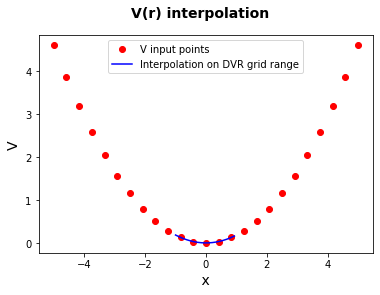


 Completed construction of Hamiltonian 


In [3]:
#===========================================================================================
#  Plot potential on the DVR grid points on which the wavefunction is defined
#  and ALSO the interpolation to check we are using the potential that we mean to.
#
print("\n Plot potential ")
x_Plot = []
pot_Plot = []
for j in range(0,n_vals_pot):
    x_Plot.append(r_vals_X_state[j])
    pot_Plot.append( V_vals_X_state[j])
plt.suptitle('V(r) interpolation', fontsize=14, fontweight='bold')
string="V input points"
plt.plot(x_Plot,pot_Plot,'ro',label=string)
#
x_Plot = []
pot_Plot = []
Number_plot_points = 1000
dx = (dvr.x_pts[dvr.nbas-1] - dvr.x_pts[0])/float(Number_plot_points-1)
time = 0.0 # dummy time in general call to potential function
for j in range(0,Number_plot_points):
    x= dvr.x_pts[0] + j*dx
    x_Plot.append(x)
    pot_Plot.append(vectorized_V_X_state(x,time))
plt.plot(x_Plot,pot_Plot,'-b',label="Interpolation on DVR grid range")
plt.legend(loc="best")
plt.xlabel(" x ", fontsize=14)
plt.ylabel("V", fontsize=14)
print("\n Running from terminal, close figure window to proceed and make .pdf file of figure")
#   Insert limits if necessary
#xmax = float(rmax)  # CWM: need to use float() to get plt.xlim to work to set x limits
#plt.xlim([0,xmax])
#number_string = str(a)
plt.savefig('Plot_Output/' + 'Plot_potential' + '.pdf', transparent=False)
plt.show()
#
#
# =============Build Hamiltonian (using general routine with dummy time t=0)=========
#     Pass name of potential function explicitly here
time = 0.0
H_mat = dvr.Hamiltonian(vectorized_V_X_state, time)
print("\n Completed construction of Hamiltonian ")


            Lowest  30    Eigenvalues of the DVR Hamiltonian 

E(  0 ) =    0.007084360891317871  hartrees, excitation energy =  0.0  cm^-1
E(  1 ) =    0.021253082784699305  hartrees, excitation energy =  3109.675014437591  cm^-1
E(  2 ) =    0.03542180196166095  hartrees, excitation energy =  6219.34943268995  cm^-1
E(  3 ) =    0.04959055566371834  hartrees, excitation energy =  9329.031428324972  cm^-1
E(  4 ) =    0.06375920314918633  hartrees, excitation energy =  12438.690112113189  cm^-1
E(  5 ) =    0.07792897024870564  hartrees, excitation energy =  15548.59452278259  cm^-1
E(  6 ) =    0.09210000567145121  hartrees, excitation energy =  18658.777298224526  cm^-1
E(  7 ) =    0.10628722484899542  hartrees, excitation energy =  21772.51199728496  cm^-1
E(  8 ) =    0.12052679980877293  hartrees, excitation energy =  24897.737462350782  cm^-1
E(  9 ) =    0.13489662382123355  hartrees, excitation energy =  28051.549290239636  cm^-1
E(  10 ) =    0.14968504302209143  hartrees, 

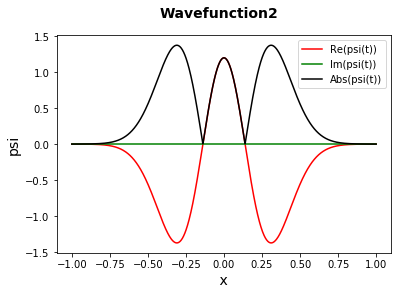


 Average value of r using DVR for the integral, <r> =  -3.8111765459428406e-15

 Running from terminal, close figure window to proceed and make .pdf file of figure


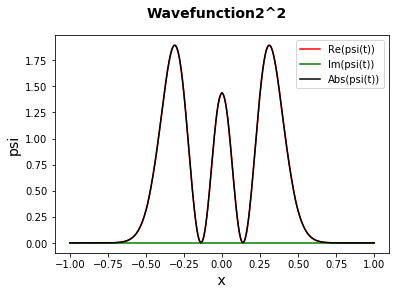

In [4]:
#====================================================================================
#
# Find all the eigenvalues of the Hamiltonian so we can compare with known bound state energies
# or make a plot of the spectrum -- For a time-independent Hamiltonian example here
#
EigenVals = LA.eigvalsh(H_mat)
#
n_energy = 30 
print("\n            Lowest ", n_energy,"   Eigenvalues of the DVR Hamiltonian \n")
for  i in range(0,n_energy):
     print("E( ",i,") =   ",EigenVals[i]," hartrees, excitation energy = ",(EigenVals[i]-EigenVals[0])* Hartree_to_wavenumber," cm^-1")
#====================================================================================
#
# Extract the n_Plot'th eigenfunction for plotting and use as initial wave function
# to test propagation
#
number_of_eigenvectors = n_energy 
#
#  Here n_Plot picks which eigenfunction to plot
n_Plot = 2  # pick a state of this potential to plot < number_of_eigenvectors -1
#
print("Calculating ",number_of_eigenvectors," eigenvectors for plotting eigenfunctions")
EigenVals, EigenVecs  = LA.eigh(H_mat,eigvals=(0,number_of_eigenvectors))
wfcnPlot = []
for j in range(0,dvr.nbas):
    wfcnPlot.append(EigenVecs[j,n_Plot])
#
# normalize  wave function from diagonalization
#
norm_squared = 0.
for j in range(0,dvr.nbas):
    norm_squared = norm_squared + np.abs(wfcnPlot[j])**2    
wfcnPlot = wfcnPlot/np.sqrt(norm_squared)
norm_squared = 0.
for j in range(0,dvr.nbas):
    norm_squared = norm_squared + np.abs(wfcnPlot[j])**2    
print("Norm of wave function being plotted is ", np.sqrt(norm_squared))
#
#================# Plot the  wave function specified by n_Plot above======================
#   It must be type np.complex for this general wave function plotting logic
#
Cinitial  = np.zeros((dvr.nbas), dtype=complex) 
wfcnInitialPlot  = np.zeros((dvr.nbas), dtype=complex) 
for j in range(0,dvr.nbas):
   Cinitial[j] = wfcnPlot[j]
#
print("\n Plot wave function ",n_Plot," (numbered in order of increasing energy)")
title = 'Wavefunction'+str(n_Plot)
#  note that the dvr.Plot_Psi function makes a .pdf file in the Plot_Output directory
#  That's what make_plot=True controls.  
x_Plot_array, Psi_plot_array = dvr.Plot_Psi(Cinitial, plot_title_string=title,N_plot_points=Number_plot_points,make_plot=True)
# write the data in file also
for j in range(0,Number_plot_points):
    print(x_Plot_array[j],"  ",np.real(Psi_plot_array[j]),"  ",np.imag(Psi_plot_array[j]),file=wfcn_plotfile)
print("&  \n ",file=wfcn_plotfile)
#
# plot square of wave function (radial probability distribution)
#
Csquared=np.zeros(dvr.nbas,dtype=complex)
raverage = 0.0
for i in range(dvr.nbas):
   Csquared[i] = np.abs(Cinitial[i])**2 / np.sqrt(dvr.w_pts[i+1])
#   compute <r> for this wave function
#   note that Cinitial[i] contains the necessary weight, sqrt(dvr.w_pts[i+1])
   raverage = raverage + np.abs(Cinitial[i])**2 *dvr.x_pts[i+1]
print("\n Average value of r using DVR for the integral, <r> = ",raverage)
title = 'Wavefunction'+str(n_Plot)+"^2"
#  note that the dvr.Plot_Psi function makes a .pdf file in the Plot_Output directory
#  That's what make_plot=True controls.  
x_Plot_array, Psi_plot_array = dvr.Plot_Psi(Csquared, plot_title_string=title,N_plot_points=Number_plot_points,make_plot=True)
# write the data in file also
for j in range(0,Number_plot_points):
    print(x_Plot_array[j],"  ",np.real(Psi_plot_array[j]),"  ",np.imag(Psi_plot_array[j]),file=wfcn_plotfile)
print("&  \n ",file=wfcn_plotfile)
#
#exit()

In [26]:
mass = (1*1822.89)
omega = np.sqrt(0.36881361766800008/mass)
hbar = 1

In [27]:
Ev_exact = (2.5)*hbar*omega

In [28]:
Ev_exact

0.03556012275231627

In [29]:
# this is the difference between the estimated and the exact. They are very similar
difference = Ev_exact - 0.03542180196166095
difference

0.00013832079065532327

In [ ]:
exit()